In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.nn import init
import time

In [2]:
# dataloader arguments
batch_size = 128
data_path='./kmnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.KMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.KMNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
# Network Architecture
num_inputs = 28*28
num_hidden = 2000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class my_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        #self.fc2 = nn.Linear(num_hidden, num_hidden)
        #self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        #mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk1_rec = []
        mem1_rec = []
        #spk2_rec = []
        #mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            #cur2 = self.fc2(spk1)
            #spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

def generate_spike(x):
    data_input = x.view(128,-1)
    spk_input = []
    for batch in range(128):
        spk_input_batch = spikegen.rate(data_input[batch], num_steps = 25)
        spk_input.append(spk_input_batch)
    return torch.stack(spk_input, dim = 1)

In [4]:
# Load the network onto CUDA if available
net = my_Net().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#generate train data
num_epochs = 1
train_result = []
train_tgt = []
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    # Train set
    with torch.no_grad():
        net.eval()
        for train_data, train_targets in train_batch:
            train_data = train_data.to(device)
            train_targets = train_targets.to(device)
            # Test set forward pass
            train_spk, train_mem = net(generate_spike(train_data))
                
            train_tgt.append(train_targets)
            train_result.append(train_spk)
    
            iter_counter += 1
            if iter_counter == 400:
                break

train_input = torch.stack(train_result, dim=0).sum(dim = 1)
train_t = torch.stack(train_tgt, dim=0)

In [5]:
start_time = time.time()
train_net = torch.nn.Linear(num_hidden,10)
optimizer1 = torch.optim.Adam(train_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
my_train_loss_hist = []
train_accuracy_hist = []
test_accuracy_hist = []
for batch in range(400):
    train_net_out = train_net(train_input[batch])
    max_value_train, max_index_train = train_net_out.max(dim=1)
    train_accuracy = (max_index_train == train_t[batch]).sum()/128
    train_accuracy_hist.append(train_accuracy)
    # test my net
    num_epochs = 1
    my_test_result = []
    my_test_tgt = []
    for epoch in range(num_epochs):
        iter_counter = 0
        
        test_batch = iter(test_loader)
        # Test set
        with torch.no_grad():
            net.eval()
            for my_test_data, my_test_targets in test_batch:
                my_test_data = my_test_data.to(device)
                my_test_targets = my_test_targets.to(device)
                # Test set forward pass
                my_test_spk, my_test_mem = net(generate_spike(my_test_data))
                
                my_test_tgt.append(my_test_targets)
                my_test_result.append(my_test_spk)
    
                iter_counter += 1
                if iter_counter == 50:
                    break
                    
    max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)).max(dim=2)
    testacc = sum(max_index.reshape(-1) == torch.stack(my_test_tgt, dim=0).reshape(-1))/6400
    test_accuracy_hist.append(testacc)
    
    train_loss = torch.zeros((1), dtype=dtype, device=device)
    train_loss = loss(train_net_out, train_t[batch])
    # Gradient calculation + weight update
    optimizer1.zero_grad()
    train_loss.backward()
    optimizer1.step()
    my_train_loss_hist.append(train_loss.item())
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"操作所花费的时间为: {elapsed_time} 秒")

操作所花费的时间为: 7294.851669788361 秒


In [11]:
# 将列表转换为 NumPy 数组
arr0 = np.array(my_train_loss_hist)

# 保存数组到 .npy 文件
np.save('train_loss_kmnist.npy', arr0)

# 将列表转换为 NumPy 数组
arr1 = np.array(train_accuracy_hist)

# 保存数组到 .npy 文件k
np.save('train_accuracy_kmnist.npy', arr1)

# 将列表转换为 NumPy 数组
arr2 = np.array(test_accuracy_hist)

# 保存数组到 .npy 文件
np.save('test_accuracy_kmnist.npy', arr2)

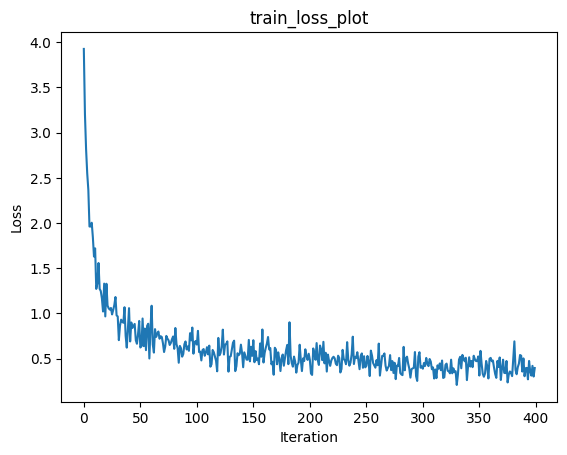

In [13]:
plt.plot(my_train_loss_hist)
plt.title("train_loss_plot")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

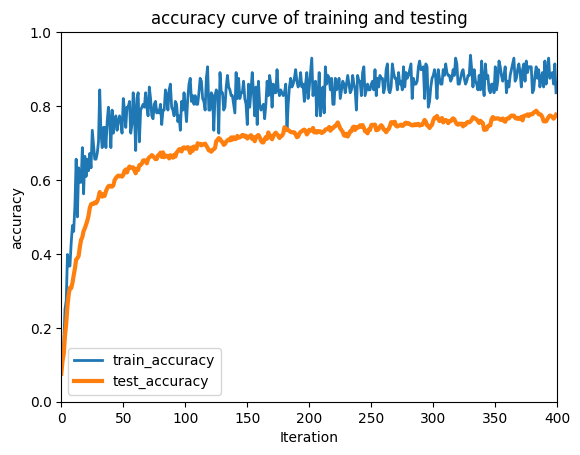

In [14]:
plt.plot(train_accuracy_hist,label = "train_accuracy", linewidth = 2)
plt.plot(test_accuracy_hist, label = "test_accuracy", linewidth = 3)
plt.title("accuracy curve of training and testing")
plt.xlim((0,400))
plt.ylim((0,1))
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("accuracy")
plt.show()

In [21]:
train_accuracy_hist

[tensor(0.0859),
 tensor(0.1562),
 tensor(0.1484),
 tensor(0.1719),
 tensor(0.2188),
 tensor(0.2891),
 tensor(0.2734),
 tensor(0.3750),
 tensor(0.4688),
 tensor(0.4531),
 tensor(0.4609),
 tensor(0.4688),
 tensor(0.4453),
 tensor(0.6016),
 tensor(0.5469),
 tensor(0.5703),
 tensor(0.6484),
 tensor(0.6016),
 tensor(0.5938),
 tensor(0.6250),
 tensor(0.6250),
 tensor(0.6797),
 tensor(0.6719),
 tensor(0.7422),
 tensor(0.6406),
 tensor(0.6484),
 tensor(0.7031),
 tensor(0.6641),
 tensor(0.7812),
 tensor(0.7031),
 tensor(0.6562),
 tensor(0.6875),
 tensor(0.7031),
 tensor(0.7734),
 tensor(0.7812),
 tensor(0.8047),
 tensor(0.7500),
 tensor(0.7266),
 tensor(0.7188),
 tensor(0.6641),
 tensor(0.7188),
 tensor(0.7656),
 tensor(0.7656),
 tensor(0.7344),
 tensor(0.7578),
 tensor(0.7656),
 tensor(0.7422),
 tensor(0.7422),
 tensor(0.7031),
 tensor(0.8125),
 tensor(0.7578),
 tensor(0.7656),
 tensor(0.7266),
 tensor(0.7266),
 tensor(0.8203),
 tensor(0.8047),
 tensor(0.7969),
 tensor(0.7734),
 tensor(0.7344

In [22]:
test_accuracy_hist

[tensor(0.0911),
 tensor(0.1141),
 tensor(0.1488),
 tensor(0.1658),
 tensor(0.1881),
 tensor(0.2166),
 tensor(0.2398),
 tensor(0.2694),
 tensor(0.2959),
 tensor(0.3133),
 tensor(0.3395),
 tensor(0.3684),
 tensor(0.3909),
 tensor(0.4009),
 tensor(0.4244),
 tensor(0.4364),
 tensor(0.4525),
 tensor(0.4648),
 tensor(0.4659),
 tensor(0.4805),
 tensor(0.5083),
 tensor(0.5167),
 tensor(0.5256),
 tensor(0.5316),
 tensor(0.5466),
 tensor(0.5586),
 tensor(0.5648),
 tensor(0.5673),
 tensor(0.5609),
 tensor(0.5620),
 tensor(0.5680),
 tensor(0.5666),
 tensor(0.5714),
 tensor(0.5802),
 tensor(0.5794),
 tensor(0.5895),
 tensor(0.5775),
 tensor(0.5905),
 tensor(0.5956),
 tensor(0.5977),
 tensor(0.6005),
 tensor(0.6017),
 tensor(0.6155),
 tensor(0.6119),
 tensor(0.6097),
 tensor(0.6108),
 tensor(0.6250),
 tensor(0.6233),
 tensor(0.6258),
 tensor(0.6258),
 tensor(0.6242),
 tensor(0.6212),
 tensor(0.6123),
 tensor(0.6141),
 tensor(0.6167),
 tensor(0.6192),
 tensor(0.6102),
 tensor(0.6239),
 tensor(0.6237

In [ ]:
# test my net
my_test_result = []
my_test_tgt = []
for epoch in range(num_epochs):
    iter_counter = 0
    test_batch = iter(test_loader)
    # Test set
    with torch.no_grad():
        net.eval()
        for my_test_data, my_test_targets in test_batch:
            my_test_data = my_test_data.to(device)
            my_test_targets = my_test_targets.to(device)
            # Test set forward pass
            my_test_spk, my_test_mem = net(generate_spike(my_test_data))
                
            my_test_tgt.append(my_test_targets)
            my_test_result.append(my_test_spk)
    
            iter_counter += 1
            if iter_counter == 50:
                break
                    
max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)).max(dim=2)
testacc = sum(max_index.reshape(-1) == torch.stack(my_test_tgt, dim=0).reshape(-1))/6400

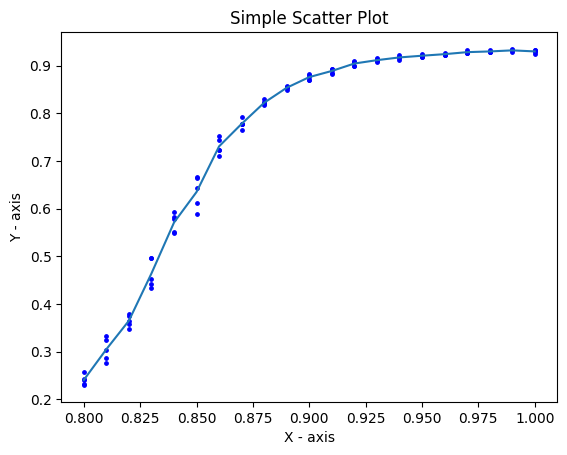

In [81]:
x_label = 0.8+0.01*torch.arange(0,21)
y_mean_list = []
# 绘制散点图
for i in range(21):
    x = x_label[i].repeat(5)
    y = test_acc_list[i]
    y_mean = y.mean()
    y_mean_list.append(y_mean)
    plt.scatter(x, y, s = 6, c='blue')
plt.plot(x_label,y_mean_list)
plt.title("Simple Scatter Plot")
plt.xlabel("X - axis")
plt.ylabel("Y - axis")
plt.show()

In [13]:
# Plot Loss
# fig = plt.figure(facecolor="w", figsize=(10, 5))
# plt.plot(my_train_loss_hist)
# plt.title("my_train_loss_hist")
# plt.legend(["my_train_loss_hist"])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()